In [4]:
import os 
import opendssdirect as dss
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az
import networkx as nx
import pandapower as pp
import pandapower.networks as pn

from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV
import math
import pytensor
import pickle
import random

# Gathered data (from oedi)

In [2]:
to_save_folder=r'C:\Users\hoc\Documents\Henrique\Doutorado\codigos_linux\dev\phd\papers\artigo_3_phase_synthetic\generated_data'

prob_3_phases=pickle.load(open(os.path.join(to_save_folder,'prob_3_phases.pickle'),'rb'))

phases_proportion=pickle.load(open(os.path.join(to_save_folder,'phases_proportion.pickle'),'rb'))

phases_planning=pickle.load(open(os.path.join(to_save_folder,'phases_planning.pickle'),'rb'))

power_df=pickle.load(open(os.path.join(to_save_folder,'power_df.pickle'),'rb'))

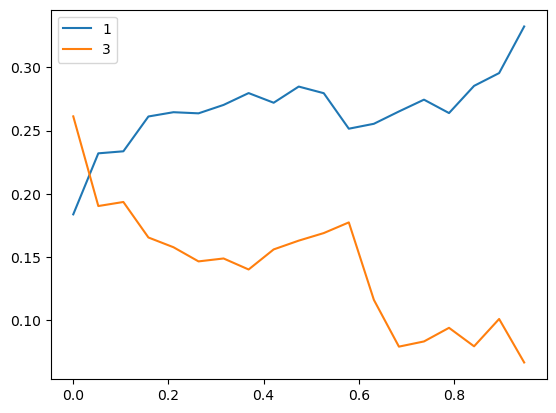

In [29]:
plt.plot(prob_3_phases[1].keys(),prob_3_phases[1].values(),label='1')
#plt.plot(prob_3_phases[2].keys(),prob_3_phases[2].values(),label='2')
plt.plot(prob_3_phases[3].keys(),prob_3_phases[3].values(),label='3')
plt.legend()
plt.show()

# Initial required input:
1) a graph representing the distribution system (I put a pandapower network and turn it into a graph manually)
- this is saved in graph_from_net variable. you can change this as you wish
- x and y coordinates must be saved as node attributes
2) the aggregated power (sum of all phases) for each node graph (a node graph is a load, in this case)
- this is saved in aggregated_power dict
3) (optional) phases_proportion
- the proportion of activer power that will be in each phase for 3 phase loads. by default it is set based on oedi data.
- this is saved in phases_proportion
example: phases_proportion[5]=[0.1,0.4,0.6] means that node 5 will have 10% (respectively 40% and 60%) of its total demand on phase A (respectively in phases B and C)
4) (optional) phases_choice
- the probability of choosing a given phase, for single phase loads. by default it is set based on oedi data
- this is saved in p_phases_choice
example: phases_proportion[5]=[0.1,0.4,0.6] means that, if node 5 is single phase, it will have 10% (respectively 40% and 60%) chance of choosing phase A (respectively in phases B and C) to connect

the graph must be georeferenced

In [20]:
net=pp.networks.case145()
graph_from_net=pp.topology.create_nxgraph(net,include_trafos=False,multi=False)

# defining x and y coordinates for each bus

x_dict={}
y_dict={}

for bus_idx in net.bus.index:
    x_dict[bus_idx]=net.bus_geodata.at[bus_idx,'x']
    y_dict[bus_idx]=net.bus_geodata.at[bus_idx,'y']

nx.set_node_attributes(graph_from_net,x_dict,'x')
nx.set_node_attributes(graph_from_net,y_dict,'y')


# defining the x and y for the gen
bus_gen=net.gen.at[0,'bus']
x_gen=net.bus_geodata.at[bus_gen,'x']
y_gen=net.bus_geodata.at[bus_gen,'y']

#calculating max distance (from a given node to feeder)

max_distance=0
for node in graph_from_net.nodes:
    x=graph_from_net.nodes[node]['x']
    y=graph_from_net.nodes[node]['y']
    distance=np.sqrt((x-x_gen)**2+(y-y_gen)**2)
    if(distance>max_distance):
        max_distance=distance

print(max_distance)

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anacon

9.41006176730768


### Aggregated power 
* saved in aggregated_power_dict

In [21]:
aggregated_power_dict={}

node_list=list(graph_from_net.nodes)
node_list.sort()

for bus in node_list:
    planning_idx=random.choice(range(len(phases_planning)))
    aggregated_power_dict[bus]=sum(phases_planning[planning_idx])

### Phases proportion 
* defining as user input to see how the model is able to deal with it
* this phases proportion is only considered for three phase loads


In [22]:
phases_proportion=np.zeros(shape=(len(node_list),3))
for bus in node_list:
    phases_proportion[bus][:]=[0.1,0.1,0.8]

### Phases choice


In [112]:
p_phases_choice=[0.05,0.9,0.05]

### Variables generated from the combination of gathered data + the input graph
1) phases_line_list: number of phases for each line
2) prob_three_phase_dict: Probability of being 3-phase for each node in the graph

These variables will be used in the bayesian model to generate the samples

In [19]:
phases_line_list=[]
prop_three_phase_dict={}
normalized_dist_dict={}

for u,v in graph_from_net.edges():
    x_line=graph_from_net.nodes[v]['x']
    y_line=graph_from_net.nodes[v]['y']
    distance_from_feeder=np.sqrt((x_line-x_gen)**2+(y_line-y_gen)**2)
    normalized_dist=distance_from_feeder/max_distance
    #print(normalized_dist)
    

    rounded_dist=0
    for distance_key in prob_3_phases[1].keys():
        if(distance_key>normalized_dist):
            rounded_dist=distance_key
            break

    individual_prob_list=np.cumsum([prob_3_phases[1][rounded_dist],prob_3_phases[2][rounded_dist],prob_3_phases[3][rounded_dist]])

    random_number=np.random.rand() #random for line
    if(random_number<=individual_prob_list[0]):
        phases_line_list.append(1)
    elif(random_number<=individual_prob_list[1]):
        phases_line_list.append(2)
    else:
        phases_line_list.append(3)

for u in node_list:
    x_line=graph_from_net.nodes[u]['x']
    y_line=graph_from_net.nodes[u]['y']
    distance_from_feeder=np.sqrt((x_line-x_gen)**2+(y_line-y_gen)**2)
    normalized_dist=distance_from_feeder/max_distance
    normalized_dist_dict[u]=normalized_dist
    #print(normalized_dist)

    rounded_dist=0
    for distance_key in prob_3_phases[1].keys():
        if(distance_key>normalized_dist):
            rounded_dist=distance_key
            break

    #individual_prob_list=np.cumsum([prob_3_phases[1][rounded_dist],prob_3_phases[2][rounded_dist],prob_3_phases[3][rounded_dist]])


    prop_three_phase_dict[u]=prob_3_phases[3][rounded_dist]


NameError: name 'graph_from_net' is not defined

### Generating ipymc model

In [115]:
#num_single_loads
#num_three_phase_loads
#phases_planning
#phases_proportion

with pm.Model() as three_phase_model:
    feeder_idx=0


    # proportion of each phase
    num_total_loads=len(graph_from_net.nodes)
    #num_total_loads=5
    #num_total_loads=int(num_single_loads[feeder_idx]+num_three_phase_loads[feeder_idx])
    #prop_three_phase=num_three_phase_loads[feeder_idx]/num_total_loads
    prob_three_phases_data=list(prop_three_phase_dict.values())
    #prob_three_phase=0

    three_phase_choice=pm.Bernoulli('three_phase_choice',p=prob_three_phases_data,shape=num_total_loads)



    mu_prop_a=np.mean([phases_proportion[idx][0] for idx in range(len(phases_proportion))])
    #var_prop_a=np.std([phases_proportion[idx][0] for idx in range(len(phases_proportion))])
    #prop_a=pm.TruncatedNormal('prop_a',mu=mu_prop_a,sigma=var_prop_a,shape=num_total_loads,lower=0)

    mu_prop_b=np.mean([phases_proportion[idx][1] for idx in range(len(phases_proportion))])
    #var_prop_b=np.std([phases_proportion[idx][1] for idx in range(len(phases_proportion))])
    #prop_b=pm.TruncatedNormal('prop_b',mu=mu_prop_b,sigma=var_prop_b,shape=num_total_loads,lower=0)

    mu_prop_c=np.mean([phases_proportion[idx][2] for idx in range(len(phases_proportion))])
    #var_prop_c=np.std([phases_proportion[idx][2] for idx in range(len(phases_proportion))])
    #prop_c=pm.TruncatedNormal('prop_c',mu=mu_prop_c,sigma=var_prop_c,shape=num_total_loads,lower=0)

    # phase choice



    phase_choice=pm.Categorical('phase_choice',p=p_phases_choice,shape=(num_total_loads))


    # defining load of each phase
    #mu_p_a=np.mean([phases_planning[idx][0] for idx in range(len(phases_planning))])
    mu_p_a=np.array(list(aggregated_power_dict.values()))
    var_p_a=np.std([phases_planning[idx][0] for idx in range(len(phases_planning))])
    #expected_p_a=pm.Deterministic('mu_p_a',mu_p_a/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_a))) #phase a
    p_a=pm.TruncatedNormal('P_a',mu=mu_p_a,lower=0,shape=(num_total_loads))

    #mu_p_b=np.mean([phases_planning[idx][1] for idx in range(len(phases_planning))])
    mu_p_b=np.array(list(aggregated_power_dict.values()))
    var_p_b=np.std([phases_planning[idx][1] for idx in range(len(phases_planning))])
    #expected_p_b=pm.Deterministic('mu_p_b',mu_p_b/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_b))) #phase b
    p_b=pm.TruncatedNormal('P_b',mu=mu_p_b,lower=0,shape=(num_total_loads))

    #mu_p_c=np.mean([phases_planning[idx][2] for idx in range(len(phases_planning))])
    mu_p_c=np.array(list(aggregated_power_dict.values()))
    var_p_c=np.std([phases_planning[idx][2] for idx in range(len(phases_planning))])
    #expected_p_c=pm.Deterministic('mu_p_c',mu_p_c/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_c))) #phase c
    p_c=pm.TruncatedNormal('P_c',mu=mu_p_c,lower=0,shape=(num_total_loads))


    real_p_a=pm.Deterministic('real_p_a',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 0),p_a,0),p_a*mu_prop_a))
    real_p_b=pm.Deterministic('real_p_b',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 1),p_b,0),p_b*mu_prop_b))
    real_p_c=pm.Deterministic('real_p_c',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 2),p_c,0),p_c*mu_prop_c))



    power_factor_mu=np.mean(power_df.p_kw/np.sqrt(power_df.q_kvar**2+power_df.p_kw**2))  #calculating power factor for each node
    power_factor=pm.Beta('power_factor',mu=power_factor_mu,sigma=power_factor_mu*0.05,shape=num_total_loads)

    q_a=pm.TruncatedNormal('Q_a',mu=np.sqrt((mu_p_a/power_factor_mu)**2-mu_p_a**2),lower=0,shape=(num_total_loads))
    q_b=pm.TruncatedNormal('Q_b',mu=np.sqrt((mu_p_b/power_factor_mu)**2-mu_p_b**2),lower=0,shape=(num_total_loads))
    q_c=pm.TruncatedNormal('Q_c',mu=np.sqrt((mu_p_c/power_factor_mu)**2-mu_p_c**2),lower=0,shape=(num_total_loads))

    real_q_a=pm.Deterministic('real_q_a',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 0),q_a,0),q_a*mu_prop_a))
    real_q_b=pm.Deterministic('real_q_b',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 1),q_b,0),q_b*mu_prop_b))
    real_q_c=pm.Deterministic('real_q_c',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 2),q_c,0),q_c*mu_prop_c))

    #phases_planning[feeder_idx]
    #active_power_load=pm.Normal(mu=)

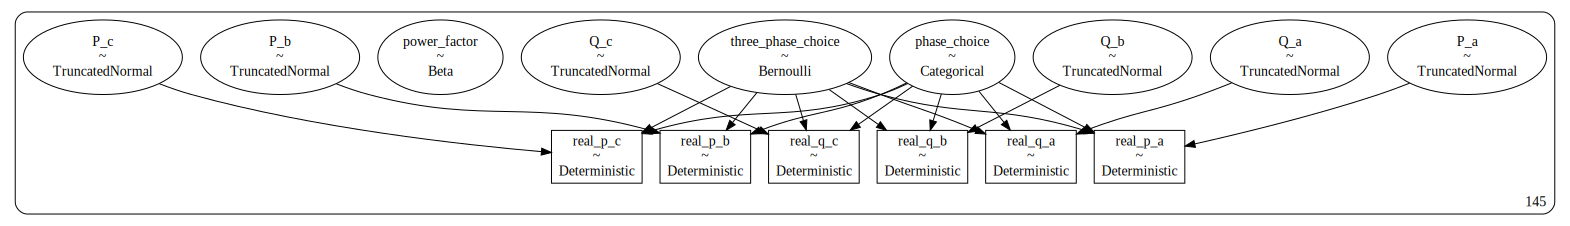

In [116]:
pm.model_to_graphviz(three_phase_model)

In [117]:
with three_phase_model:
    idata = pm.sample(draws=1000,chains=4,tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


# Results part 1 - compared generated samples with input

In [166]:
[num_chains,num_samples,num_loads]=idata.posterior['P_a'].shape

sample_idx=0

df_dict={}

load_list_a=[[] for k_idx in range(num_loads)]
load_list_b=[[] for k_idx in range(num_loads)]
load_list_c=[[] for k_idx in range(num_loads)]

df_dict=pd.DataFrame(columns=['sample_idx','node','p_a','q_a','p_b','q_b','p_c','q_c','num_phases','distance'])
for i in range(4): #chains
    print(i)
    for j in range(200): #samples
        for k in range(num_loads):
            distance=normalized_dist_dict[k]
            phase_a_p=float(idata.posterior['real_p_a'][i][j][k].values)
            phase_a_q=float(idata.posterior['real_q_a'][i][j][k].values)
            phase_b_p=float(idata.posterior['real_p_b'][i][j][k].values)
            phase_b_q=float(idata.posterior['real_q_b'][i][j][k].values)
            phase_c_p=float(idata.posterior['real_p_c'][i][j][k].values)
            phase_c_q=float(idata.posterior['real_q_c'][i][j][k].values)
            num_phases=float(idata.posterior['three_phase_choice'][i][j][k].values)
            df_dict.loc[len(df_dict)]=[sample_idx,k,phase_a_p,phase_a_q,phase_b_p,phase_b_q,phase_c_p,phase_c_q,num_phases,distance]
    
        sample_idx+=1

0
1
2
3


## a) distance x prob_phase

In [167]:
num_points=20 #number of discrete points between 0 and 1
synthetic_3_phase_choice_dict={}
num_nodes_each_distance_dict={}
point_list=np.linspace(0,1,num_points)
for point in range(num_points):
    synthetic_3_phase_choice_dict[point]=0
    num_nodes_each_distance_dict[point]=0

for sample_idx in df_dict.index:
    distance=df_dict.at[sample_idx,'distance']
    num_phases=df_dict.at[sample_idx,'num_phases']
    point_idx=0
    while(point_list[point_idx]<distance):
        point_idx+=1
    synthetic_3_phase_choice_dict[point_idx]+=num_phases
    num_nodes_each_distance_dict[point_idx]+=1

for point_idx in synthetic_3_phase_choice_dict.keys():
    if(synthetic_3_phase_choice_dict[point_idx]!=0):
        synthetic_3_phase_choice_dict[point_idx]/=num_nodes_each_distance_dict[point_idx]


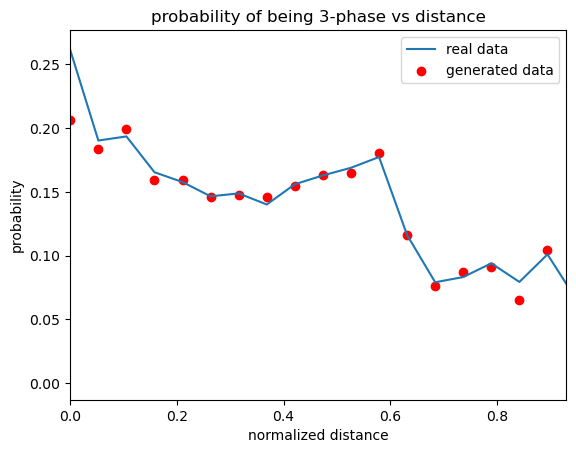

In [168]:
#plt.plot(prob_3_phases[1].keys(),prob_3_phases[1].values(),label='1')
#plt.plot(prob_3_phases[2].keys(),prob_3_phases[2].values(),label='2')
plt.plot(prob_3_phases[3].keys(),prob_3_phases[3].values(),label='real data')
x_axis=[normalized_dist_dict[idx] for idx in node_list]
#plt.scatter(x_axis,prob_three_phases_data,label='generated data',color='red')
plt.scatter(point_list,synthetic_3_phase_choice_dict.values(),label='generated data',color='red')
plt.legend()
plt.title('probability of being 3-phase vs distance')
plt.xlim([0,0.93])
plt.xlabel('normalized distance')
plt.ylabel('probability')
plt.show()


## b) histplot for active and reactive power
* how does it compare with the aggregated power taken as input
* how does the unbalanced factor compared with real data

## b.1) comparing with the aggregated power - single phase

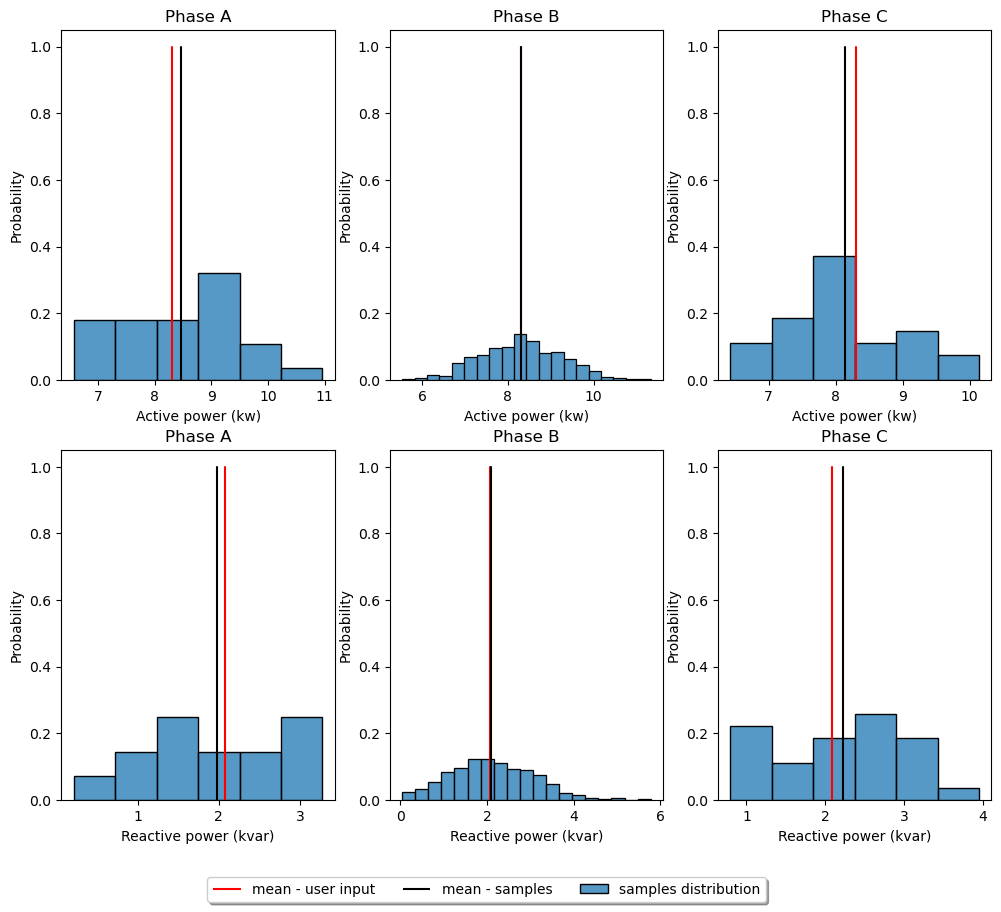

In [169]:
fig,axs=plt.subplots(2,3,figsize=(12,10))


node_idx=0
## active power

#phase A
hist_p_a=df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==0.0) & (df_dict.p_a!=0)].p_a
sns.histplot(hist_p_a,label='samples distribution',ax=axs[0][0],stat='probability')
axs[0][0].set_xlabel('Active power (kw)')
axs[0][0].set_title('Phase A')
axs[0][0].vlines(aggregated_power_dict[node_idx],0,1,label='mean - user input',colors='red')
axs[0][0].vlines(np.mean(hist_p_a),0,1,label='mean - samples',colors='black')
#phase B
hist_p_b=df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==0.0) & (df_dict.p_b!=0)].p_b
sns.histplot(hist_p_b,label='samples distribution',ax=axs[0][1],stat='probability')
axs[0][1].set_xlabel('Active power (kw)')
axs[0][1].set_title('Phase B')
axs[0][1].vlines(aggregated_power_dict[node_idx],0,1,label='mean - user input',colors='red')
axs[0][1].vlines(np.mean(hist_p_b),0,1,label='mean - samples',colors='black')
#phase C
hist_p_c=df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==0.0) & (df_dict.p_c!=0)].p_c
sns.histplot(hist_p_c,label='samples distribution',ax=axs[0][2],stat='probability')
axs[0][2].set_xlabel('Active power (kw)')
axs[0][2].set_title('Phase C')
axs[0][2].vlines(aggregated_power_dict[node_idx],0,1,label='mean - user input',colors='red')
axs[0][2].vlines(np.mean(hist_p_c),0,1,label='mean - samples',colors='black')


## reactive power
power_factor=power_factor_mu

#phase A
hist_p_a=df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==0.0) & (df_dict.p_a!=0)].q_a
sns.histplot(hist_p_a,label='samples distribution',ax=axs[1][0],stat='probability')
axs[1][0].set_xlabel('Reactive power (kvar)')
axs[1][0].set_title('Phase A')
axs[1][0].vlines(np.sqrt((aggregated_power_dict[node_idx]/power_factor)**2-aggregated_power_dict[node_idx]**2),0,1,label='mean - user input',colors='red')
axs[1][0].vlines(np.mean(hist_p_a),0,1,label='mean - samples',colors='black')
#phase B
hist_p_b=df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==0.0) & (df_dict.p_b!=0)].q_b
sns.histplot(hist_p_b,label='samples distribution',ax=axs[1][1],stat='probability')
axs[1][1].set_xlabel('Reactive power (kvar)')
axs[1][1].set_title('Phase B')
axs[1][1].vlines(np.sqrt((aggregated_power_dict[node_idx]/power_factor)**2-aggregated_power_dict[node_idx]**2),0,1,label='mean - user input',colors='red')
axs[1][1].vlines(np.mean(hist_p_b),0,1,label='mean - samples',colors='black')
#phase C
hist_p_c=df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==0.0) & (df_dict.p_c!=0)].q_c
sns.histplot(hist_p_c,label='samples distribution',ax=axs[1][2],stat='probability')
axs[1][2].set_xlabel('Reactive power (kvar)')
axs[1][2].set_title('Phase C')
axs[1][2].vlines(np.sqrt((aggregated_power_dict[node_idx]/power_factor)**2-aggregated_power_dict[node_idx]**2),0,1,label='mean - user input',colors='red')
axs[1][2].vlines(np.mean(hist_p_c),0,1,label='mean - samples',colors='black')



plt.legend(loc='upper right', bbox_to_anchor=(0.2, -0.2),
          fancybox=True, shadow=True, ncol=5)

plt
plt.show()

In [170]:
aggregated_power_dict[node_idx]*mu_prop_c

6.6402399999999995

## b.2) comparing with the aggregated power - three phase

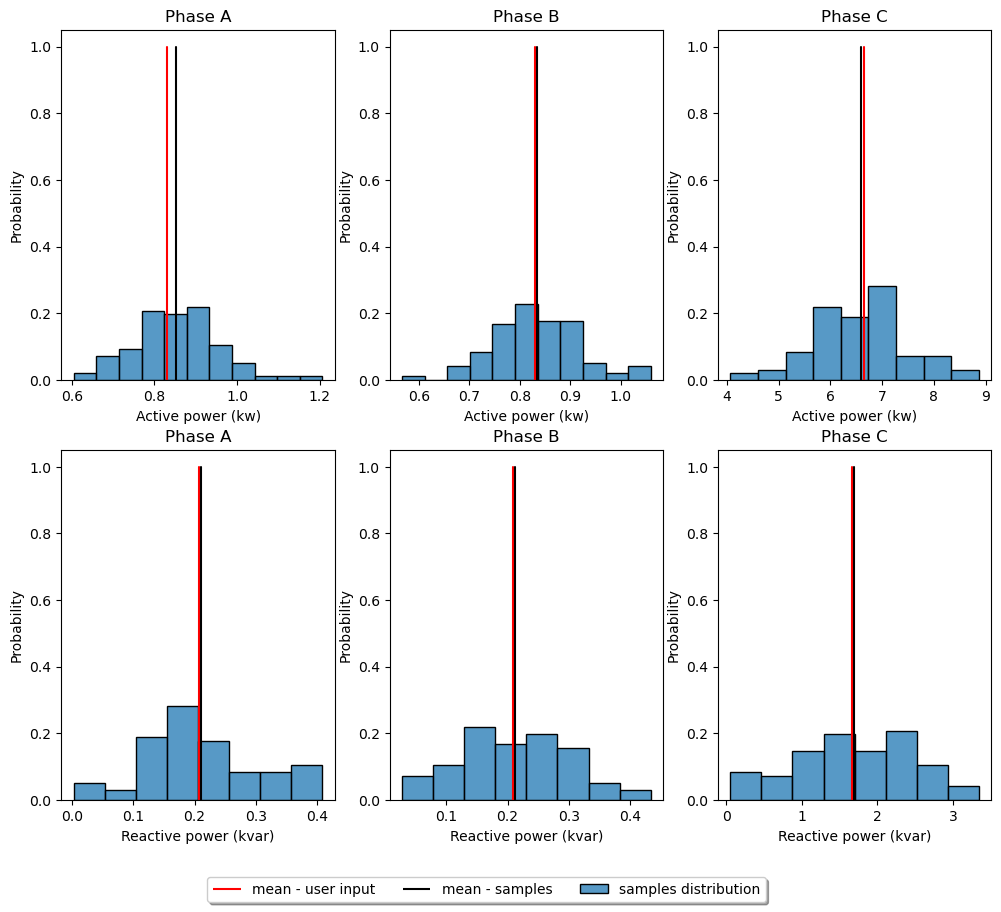

In [171]:
fig,axs=plt.subplots(2,3,figsize=(12,10))


node_idx=0
## active power

#phase A
hist_p_a=df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==1.0) & (df_dict.p_a!=0)].p_a
sns.histplot(hist_p_a,label='samples distribution',ax=axs[0][0],stat='probability')
axs[0][0].set_xlabel('Active power (kw)')
axs[0][0].set_title('Phase A')
axs[0][0].vlines(aggregated_power_dict[node_idx]*mu_prop_a,0,1,label='mean - user input',colors='red')
axs[0][0].vlines(np.mean(hist_p_a),0,1,label='mean - samples',colors='black')
#phase B
hist_p_b=df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==1.0) & (df_dict.p_b!=0)].p_b
sns.histplot(hist_p_b,label='samples distribution',ax=axs[0][1],stat='probability')
axs[0][1].set_xlabel('Active power (kw)')
axs[0][1].set_title('Phase B')
axs[0][1].vlines(aggregated_power_dict[node_idx]*mu_prop_b,0,1,label='mean - user input',colors='red')
axs[0][1].vlines(np.mean(hist_p_b),0,1,label='mean - samples',colors='black')
#phase C
hist_p_c=df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==1.0) & (df_dict.p_c!=0)].p_c
sns.histplot(hist_p_c,label='samples distribution',ax=axs[0][2],stat='probability')
axs[0][2].set_xlabel('Active power (kw)')
axs[0][2].set_title('Phase C')
axs[0][2].vlines(aggregated_power_dict[node_idx]*mu_prop_c,0,1,label='mean - user input',colors='red')
axs[0][2].vlines(np.mean(hist_p_c),0,1,label='mean - samples',colors='black')


## reactive power
power_factor=power_factor_mu

#phase A
hist_p_a=df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==1.0) & (df_dict.p_a!=0)].q_a
sns.histplot(hist_p_a,label='samples distribution',ax=axs[1][0],stat='probability')
axs[1][0].set_xlabel('Reactive power (kvar)')
axs[1][0].set_title('Phase A')
axs[1][0].vlines(np.sqrt(((aggregated_power_dict[node_idx]*mu_prop_a)/power_factor)**2-(aggregated_power_dict[node_idx]*mu_prop_a)**2),0,1,label='mean - user input',colors='red')
axs[1][0].vlines(np.mean(hist_p_a),0,1,label='mean - samples',colors='black')
#phase B
hist_p_b=df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==1.0) & (df_dict.p_b!=0)].q_b
sns.histplot(hist_p_b,label='samples distribution',ax=axs[1][1],stat='probability')
axs[1][1].set_xlabel('Reactive power (kvar)')
axs[1][1].set_title('Phase B')
axs[1][1].vlines(np.sqrt(((aggregated_power_dict[node_idx]*mu_prop_b)/power_factor)**2-(aggregated_power_dict[node_idx]*mu_prop_b)**2),0,1,label='mean - user input',colors='red')
axs[1][1].vlines(np.mean(hist_p_b),0,1,label='mean - samples',colors='black')
#phase C
hist_p_c=df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==1.0) & (df_dict.p_c!=0)].q_c
sns.histplot(hist_p_c,label='samples distribution',ax=axs[1][2],stat='probability')
axs[1][2].set_xlabel('Reactive power (kvar)')
axs[1][2].set_title('Phase C')
axs[1][2].vlines(np.sqrt(((aggregated_power_dict[node_idx]*mu_prop_c)/power_factor)**2-(aggregated_power_dict[node_idx]*mu_prop_c)**2),0,1,label='mean - user input',colors='red')
axs[1][2].vlines(np.mean(hist_p_c),0,1,label='mean - samples',colors='black')



plt.legend(loc='upper right', bbox_to_anchor=(0.2, -0.2),
          fancybox=True, shadow=True, ncol=5)

plt
plt.show()

# b.2) comparing the means: user input versus generated samples (for each node)

In [172]:
user_input_p=[]
user_input_q=[]
power_data_df=pd.DataFrame(columns=['source','power_type','phase','value'])



for node_idx in graph_from_net.nodes:
    p_a=np.mean(df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==0.0) & (df_dict.p_a!=0)].p_a)
    q_a=np.mean(df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==0.0) & (df_dict.p_a!=0)].q_a)
    p_b=np.mean(df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==0.0) & (df_dict.p_b!=0)].p_b)
    q_b=np.mean(df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==0.0) & (df_dict.p_b!=0)].q_b)
    p_c=np.mean(df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==0.0) & (df_dict.p_c!=0)].p_c)
    q_c=np.mean(df_dict[(df_dict.node==node_idx) & (df_dict.num_phases==0.0) & (df_dict.p_c!=0)].q_c)

    user_input_p=aggregated_power_dict[node_idx]
    user_input_q=np.sqrt((aggregated_power_dict[node_idx]/power_factor_mu)**2-aggregated_power_dict[node_idx]**2)

    #user input
    power_data_df.loc[len(power_data_df)]=['user_input','p','a',user_input_p]
    power_data_df.loc[len(power_data_df)]=['user_input','q','a',user_input_q]
    power_data_df.loc[len(power_data_df)]=['user_input','p','b',user_input_p]
    power_data_df.loc[len(power_data_df)]=['user_input','q','b',user_input_q]
    power_data_df.loc[len(power_data_df)]=['user_input','p','c',user_input_p]
    power_data_df.loc[len(power_data_df)]=['user_input','q','c',user_input_q]

    #real data
    power_data_df.loc[len(power_data_df)]=['real_data','p','a',p_a]
    power_data_df.loc[len(power_data_df)]=['real_data','q','b',q_a]
    power_data_df.loc[len(power_data_df)]=['real_data','p','c',p_b]
    power_data_df.loc[len(power_data_df)]=['real_data','q','a',q_b]
    power_data_df.loc[len(power_data_df)]=['real_data','p','b',p_c]
    power_data_df.loc[len(power_data_df)]=['real_data','q','c',q_c]

<Axes: xlabel='phase', ylabel='value'>

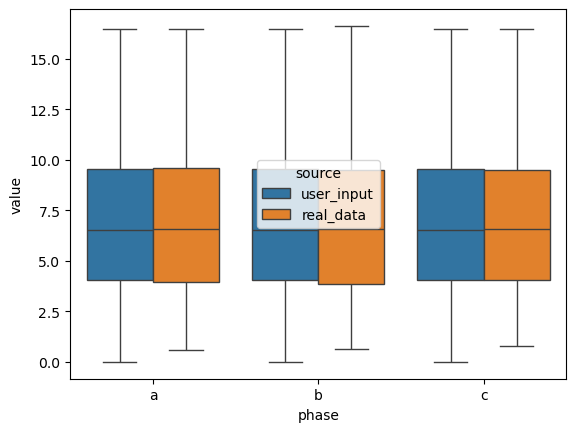

In [173]:
sns.boxplot(power_data_df[power_data_df.power_type=='p'],x='phase',y='value',hue='source')

<Axes: xlabel='phase', ylabel='value'>

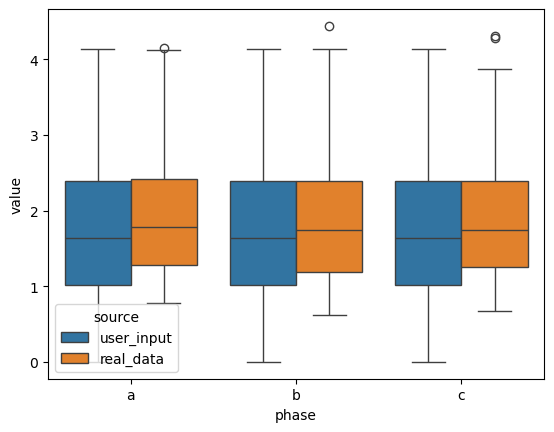

In [174]:
sns.boxplot(power_data_df[power_data_df.power_type=='q'],x='phase',y='value',hue='source')

# Results part 2 - Checking the feasibility of the generated samples
* put the active and reactive power of each sample in the pandapower (or opendss) and do a power flow analysis
* num_phases=0.0 means that the load is single phase; num_phases=1.0 means that the load is 3 phase

In [175]:
df_dict[df_dict.sample_idx==0].head()


,sample_idx,node,p_a,q_a,p_b,q_b,p_c,q_c,num_phases,distance
0,0.0,0.0,0.000000,0.00000,7.351180,2.058721,0.0,0.0,0.0,0.592910
1,0.0,1.0,0.000000,0.00000,4.828008,2.032891,0.0,0.0,0.0,0.603174
2,0.0,2.0,14.202861,2.33026,0.000000,0.000000,0.0,0.0,0.0,0.700543
3,0.0,3.0,2.711006,0.52244,0.000000,0.000000,0.0,0.0,0.0,0.677754
4,0.0,4.0,0.000000,0.00000,4.367897,2.570281,0.0,0.0,0.0,0.709918


# Results part 3 - Model evaluation in georeferenced systems
* step 1: get a graph from a real power system network that you already know the power characteristcs
* step 2: give to the bayesian hierarchical model only the mean values of active and reactive powr 
* step 3: check how close the bayesian model is from the real data of the system

In [18]:
net = pn.ieee_european_lv_asymmetric()
graph_from_net=pp.topology.create_nxgraph(net)

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anacon